# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


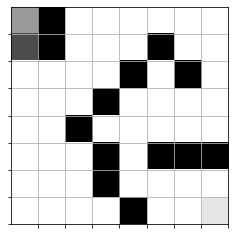

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [9]:
# Q-Training function
def qtrain(model, maze, **opt):

    global epsilon 

    # Number of training epochs
    n_epoch = opt.get('n_epoch', 15000)
    # Maximum memory size for experience replay
    max_memory = opt.get('max_memory', 1000)
    # Size of data used for training in each epoch
    data_size = opt.get('data_size', 50)

    # Record the start time of training
    start_time = datetime.datetime.now()

    # Initialize the maze environment
    qmaze = TreasureMaze(maze)
    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    # Track the history of wins
    win_history = []
    # Half the size of the maze for window size
    hsize = qmaze.maze.size // 2
    win_rate = 0.0
    
    # Training loop for each epoch
    for epoch in range(n_epoch):
        # Randomly select a free cell to start the agent
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        # Get the initial state of the environment
        envstate = qmaze.observe()
        loss = 0.0
        n_episodes = 0
        
        # Loop until the game is over
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            # Choose action: explore or exploit
            if np.random.rand() < epsilon:
                action = random.choice(qmaze.valid_actions())
            else:
                q_values = model.predict(previous_envstate)
                action = np.argmax(q_values[0])
            
            # Execute action and observe new state and reward
            envstate, reward, game_status = qmaze.act(action)
            episode = [previous_envstate, action, reward, envstate, game_status]
            # Store episode in experience replay
            experience.remember(episode)
            # Train the model using experience replay data
            inputs, targets = experience.get_data(data_size=data_size)
            loss = model.train_on_batch(inputs, targets)
            n_episodes += 1
        
        # Update win history and win rate
        win_history.append(1 if game_status == 'win' else 0)
        win_rate = sum(win_history) / len(win_history)


    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

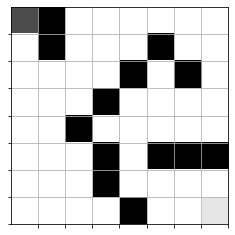

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.1040 | Episodes: 1 | Win count: 1 | Win rate: 1.000 | time: 1.4 seconds
Epoch: 001/14999 | Loss: 0.0086 | Episodes: 113 | Win count: 2 | Win rate: 1.000 | time: 9.3 seconds
Epoch: 002/14999 | Loss: 0.0010 | Episodes: 131 | Win count: 2 | Win rate: 0.667 | time: 20.0 seconds
Epoch: 003/14999 | Loss: 0.0117 | Episodes: 62 | Win count: 3 | Win rate: 0.750 | time: 24.9 seconds
Epoch: 004/14999 | Loss: 0.0010 | Episodes: 140 | Win count: 3 | Win rate: 0.600 | time: 36.3 seconds
Epoch: 005/14999 | Loss: 0.0018 | Episodes: 134 | Win count: 3 | Win rate: 0.500 | time: 47.5 seconds
Epoch: 006/14999 | Loss: 0.0008 | Episodes: 6 | Win count: 4 | Win rate: 0.571 | time: 48.3 seconds
Epoch: 007/14999 | Loss: 0.0014 | Episodes: 147 | Win count: 4 | Win rate: 0.500 | time: 62.6 seconds
Epoch: 008/14999 | Loss: 0.0011 | Episodes: 144 | Win count: 4 | Win rate: 0.444 | time: 74.1 seconds
Epoch: 009/14999 | Loss: 0.0014 | Episodes: 140 | Win count: 4 | Win rate: 0.400 | time: 

Epoch: 080/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 63 | Win rate: 0.778 | time: 357.8 seconds
Epoch: 081/14999 | Loss: 0.0012 | Episodes: 55 | Win count: 64 | Win rate: 0.780 | time: 362.5 seconds
Epoch: 082/14999 | Loss: 0.0011 | Episodes: 13 | Win count: 65 | Win rate: 0.783 | time: 363.8 seconds
Epoch: 083/14999 | Loss: 0.0010 | Episodes: 15 | Win count: 66 | Win rate: 0.786 | time: 365.2 seconds
Epoch: 084/14999 | Loss: 0.0007 | Episodes: 9 | Win count: 67 | Win rate: 0.788 | time: 366.1 seconds
Epoch: 085/14999 | Loss: 0.0012 | Episodes: 9 | Win count: 68 | Win rate: 0.791 | time: 366.9 seconds
Epoch: 086/14999 | Loss: 0.0007 | Episodes: 7 | Win count: 69 | Win rate: 0.793 | time: 367.7 seconds
Epoch: 087/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 70 | Win rate: 0.795 | time: 370.1 seconds
Epoch: 088/14999 | Loss: 0.0012 | Episodes: 29 | Win count: 71 | Win rate: 0.798 | time: 372.6 seconds
Epoch: 089/14999 | Loss: 0.0011 | Episodes: 12 | Win count: 72 | Win rate: 0

Epoch: 160/14999 | Loss: 0.0006 | Episodes: 33 | Win count: 143 | Win rate: 0.888 | time: 8.26 minutes
Epoch: 161/14999 | Loss: 0.0010 | Episodes: 1 | Win count: 144 | Win rate: 0.889 | time: 8.27 minutes
Epoch: 162/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 145 | Win rate: 0.890 | time: 8.31 minutes
Epoch: 163/14999 | Loss: 0.0008 | Episodes: 12 | Win count: 146 | Win rate: 0.890 | time: 8.33 minutes
Epoch: 164/14999 | Loss: 0.0008 | Episodes: 6 | Win count: 147 | Win rate: 0.891 | time: 8.35 minutes
Epoch: 165/14999 | Loss: 0.0004 | Episodes: 22 | Win count: 148 | Win rate: 0.892 | time: 8.38 minutes
Epoch: 166/14999 | Loss: 0.0009 | Episodes: 9 | Win count: 149 | Win rate: 0.892 | time: 8.40 minutes
Epoch: 167/14999 | Loss: 0.0010 | Episodes: 25 | Win count: 150 | Win rate: 0.893 | time: 8.43 minutes
Epoch: 168/14999 | Loss: 0.0014 | Episodes: 45 | Win count: 151 | Win rate: 0.893 | time: 8.49 minutes
Epoch: 169/14999 | Loss: 0.0013 | Episodes: 66 | Win count: 152 | Win rate: 

Epoch: 240/14999 | Loss: 0.0005 | Episodes: 46 | Win count: 223 | Win rate: 0.925 | time: 11.40 minutes
Epoch: 241/14999 | Loss: 0.0006 | Episodes: 19 | Win count: 224 | Win rate: 0.926 | time: 11.44 minutes
Epoch: 242/14999 | Loss: 0.0004 | Episodes: 15 | Win count: 225 | Win rate: 0.926 | time: 11.46 minutes
Epoch: 243/14999 | Loss: 0.0010 | Episodes: 29 | Win count: 226 | Win rate: 0.926 | time: 11.51 minutes
Epoch: 244/14999 | Loss: 0.0007 | Episodes: 9 | Win count: 227 | Win rate: 0.927 | time: 11.53 minutes
Epoch: 245/14999 | Loss: 0.0002 | Episodes: 2 | Win count: 228 | Win rate: 0.927 | time: 11.54 minutes
Epoch: 246/14999 | Loss: 0.0005 | Episodes: 19 | Win count: 229 | Win rate: 0.927 | time: 11.57 minutes
Epoch: 247/14999 | Loss: 0.0002 | Episodes: 23 | Win count: 230 | Win rate: 0.927 | time: 11.61 minutes
Epoch: 248/14999 | Loss: 0.0005 | Episodes: 2 | Win count: 231 | Win rate: 0.928 | time: 11.62 minutes
Epoch: 249/14999 | Loss: 0.0002 | Episodes: 23 | Win count: 232 | W

Epoch: 319/14999 | Loss: 0.0006 | Episodes: 9 | Win count: 302 | Win rate: 0.944 | time: 13.96 minutes
Epoch: 320/14999 | Loss: 0.0007 | Episodes: 7 | Win count: 303 | Win rate: 0.944 | time: 13.97 minutes
Epoch: 321/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 304 | Win rate: 0.944 | time: 14.02 minutes
Epoch: 322/14999 | Loss: 0.0003 | Episodes: 21 | Win count: 305 | Win rate: 0.944 | time: 14.06 minutes
Epoch: 323/14999 | Loss: 0.0005 | Episodes: 14 | Win count: 306 | Win rate: 0.944 | time: 14.08 minutes
Epoch: 324/14999 | Loss: 0.0004 | Episodes: 2 | Win count: 307 | Win rate: 0.945 | time: 14.09 minutes
Epoch: 325/14999 | Loss: 0.0009 | Episodes: 23 | Win count: 308 | Win rate: 0.945 | time: 14.12 minutes
Epoch: 326/14999 | Loss: 0.0009 | Episodes: 7 | Win count: 309 | Win rate: 0.945 | time: 14.13 minutes
Epoch: 327/14999 | Loss: 0.0003 | Episodes: 25 | Win count: 310 | Win rate: 0.945 | time: 14.16 minutes
Epoch: 328/14999 | Loss: 0.0007 | Episodes: 10 | Win count: 311 | Wi

875.116066

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

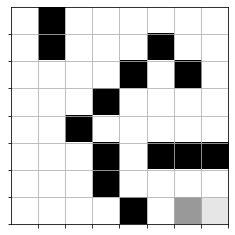

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

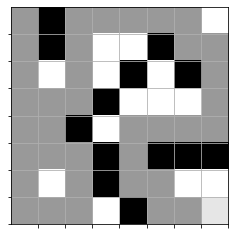

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.